In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy import signal, fft
import timeit

/home/rf/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Message specification

sps = 2
baud_rate = 19.2e3  #Bits/Second
tx_fs = sps * baud_rate # This is how many samples per second the transmitter will be sending
Tsym = 1/baud_rate

#rx_fs = .5e6
fs = tx_fs

print(f"Symbol Time {Tsym} and Symbol Freq {1/Tsym}")
print(f"TX Sample Rate {tx_fs}")


preamble = [0xAA, 0xAA, 0xAA, 0xAA, 0xAA, 0xAA, 0xAA]
syncword = [0x91,0xD7]     #Look at gold and hadamard codes, Syncword should be chosen so that there are almost and equal number of 0s and 1s, but not equal. 

Symbol Time 5.208333333333334e-05 and Symbol Freq 19200.0
TX Sample Rate 38400.0


## Packetize & Modulate Message

In [3]:
def packetize(preamble, syncword, data, dpsk=False):
    #output = bytes(preamble) + struct.pack("<BB", syncword, len(data)) + bytes(data, 'utf-8')
    output = bytes(preamble) + bytes(syncword) + bytes([len(data)]) + bytes(data, 'utf-8')
    output = np.frombuffer(output, np.uint8)
    return output

In [4]:
packet = packetize(preamble, syncword, "Biscuit does white collar crimes ")
#packet = np.insert(packet, [0], packet[0])
print(packet)
for byte in packet:
    print(hex(byte))


[170 170 170 170 170 170 170 145 215  33  66 105 115  99 117 105 116  32
 100 111 101 115  32 119 104 105 116 101  32  99 111 108 108  97 114  32
  99 114 105 109 101 115  32]
0xaa
0xaa
0xaa
0xaa
0xaa
0xaa
0xaa
0x91
0xd7
0x21
0x42
0x69
0x73
0x63
0x75
0x69
0x74
0x20
0x64
0x6f
0x65
0x73
0x20
0x77
0x68
0x69
0x74
0x65
0x20
0x63
0x6f
0x6c
0x6c
0x61
0x72
0x20
0x63
0x72
0x69
0x6d
0x65
0x73
0x20


In [5]:
def unpack_bits(packet, sps):
    #create bit string
    bit_array = np.unpackbits(packet, bitorder='big')
    return np.repeat(bit_array, sps)
unpacked = unpack_bits(packet, sps)
print(F"Number of Symbols: {len(unpacked)/sps}")

Number of Symbols: 344.0


In [6]:
def psk_mod(data, symbol_map):
    return symbol_map[data]

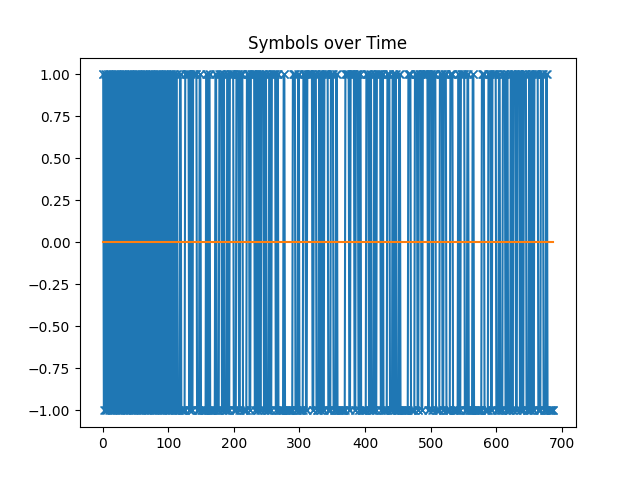

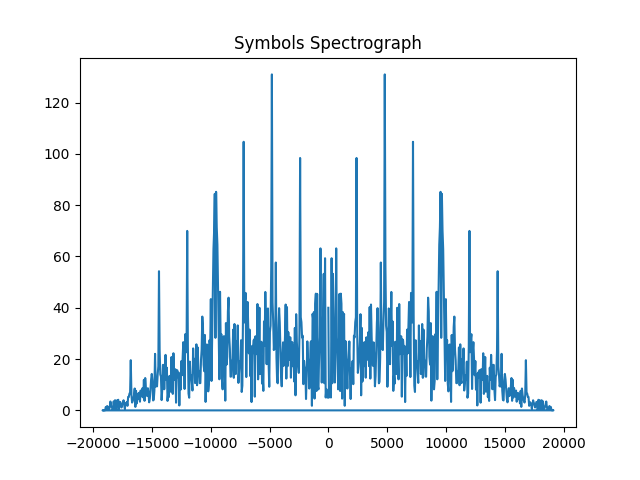

In [7]:
#bpsk_symbol_dict = {0:-1+0j, 1:1+0j}
bpsk_symbol_map = np.array([-1+0j, 1+0j])
symbols = psk_mod(unpacked, bpsk_symbol_map)

%matplotlib widget
plt.close("all")
plt.figure("Symbols over Time")
plt.title("Symbols over Time")
plt.plot(symbols.real, 'x-')
plt.plot(symbols.imag)
plt.show()

yf = fft.fft(symbols)
freqs = fft.fftfreq(symbols.size, d=1/tx_fs)

plt.figure("Symbols Spectrograph")
plt.title("Symbols Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

## Root Raised Cosine Filter
You can see that from the Symbols Spectrograph that the frequency response of this signal occupies a large bandwidth with the center lobe going from -1Mhz to +1Mhz. This corelates to -1/Ts and +1/Ts. As a result we should filter frequencies greater than +/- 1/Ts. 

The raised cosine filter does this. The RRC is derived from the sinc function (boxcar filter) and consists of 1/2 cycles of cos on either side. 

The raised cos filter is designed such that it decays to 0 in the time domain with minimal number of taps. 


31


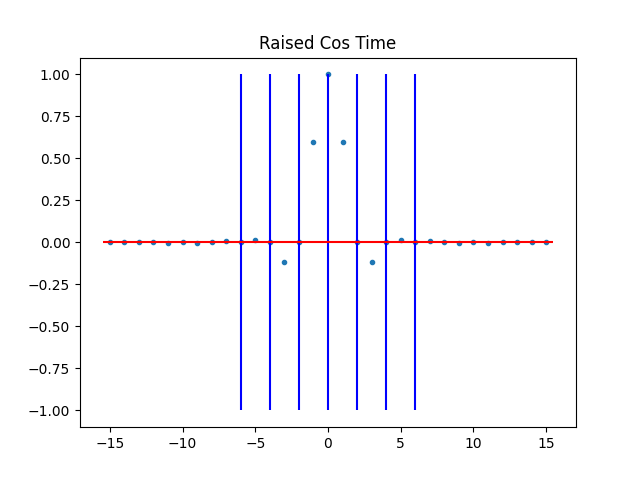

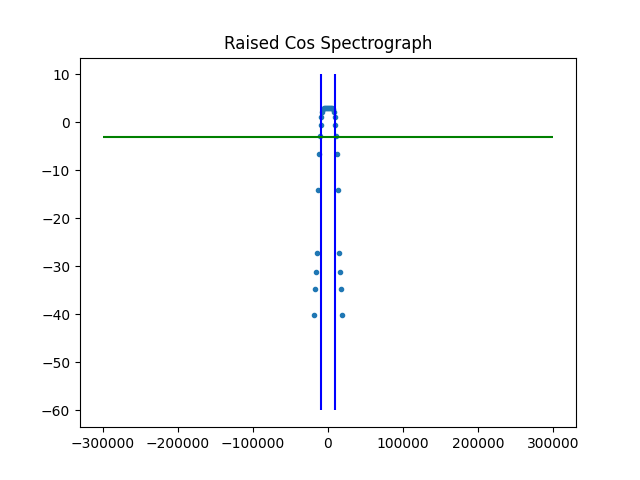

3dB attenuation at +/ Ts/2 or 9600.0


In [8]:
#Design Raised Cosine filter

ntaps = 16*sps - 1
print(ntaps)
n = np.arange(ntaps) - (ntaps-1)//2
beta = .51
Tsymbol = sps
#print(f"Tsymbol {Tsymbol}")

if Tsymbol/(2*beta) in n:
    print("Filter has a tap that will result in divide by zero error")
    print(np.where(n==T/(2*beta)))
else:
    root_raised = np.cos(np.pi*beta*n/Tsymbol)*np.sinc(n/Tsymbol)/(1-(2*beta*n/Tsymbol)**2)



%matplotlib widget
plt.close('all')
plt.figure("Raised Cos over Time")
plt.title("Raised Cos Time")
plt.plot(n, root_raised, '.')
plt.vlines(np.arange(-3*sps, 3*sps+1, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show()

yf = fft.fft(root_raised)
freqs = fft.fftfreq(root_raised.size, d=1/tx_fs)

%matplotlib widget
plt.figure("Raised Cos Spectrograph")
plt.title("Raised Cos Spectrograph")
plt.plot(freqs, 10*np.log10(np.abs(yf)), '.')
plt.vlines([baud_rate/2, -tx_fs/sps/2], -60, 10, 'b')
plt.hlines([-3], -30e4, 30e4, 'g')
plt.show()

print(f"3dB attenuation at +/ Ts/2 or {fs/sps/2}")

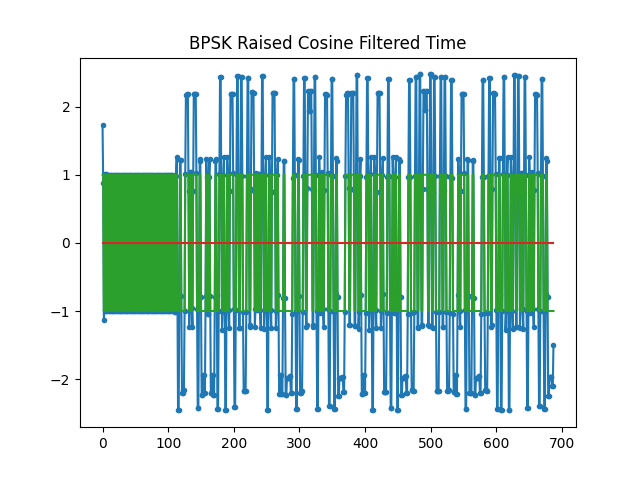

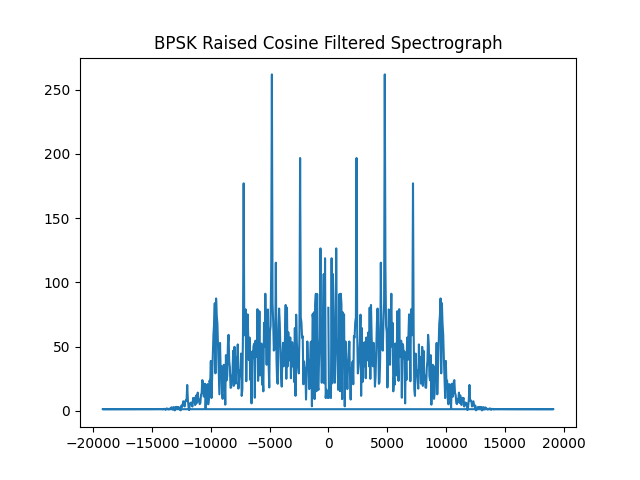

In [9]:
#Now try it on the modulated signal and see what happens
raised_cos_filtered = signal.convolve(symbols, root_raised, mode='same')


%matplotlib widget
plt.close("all")
plt.figure("BPSK Raised Cosine Filtered Time")
plt.title("BPSK Raised Cosine Filtered Time")
plt.plot(raised_cos_filtered.real, '.-')
plt.plot(raised_cos_filtered.imag)
plt.plot(symbols.real)
plt.plot(symbols.imag)

plt.show()

yf = fft.fft(raised_cos_filtered)
freqs = fft.fftfreq(raised_cos_filtered.size,d=1/tx_fs)

plt.figure("BPSK Raised Cosine Filtered Spectrograph")
plt.title("BPSK Raised Cosine Filtered Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

Correct BW: 0.51


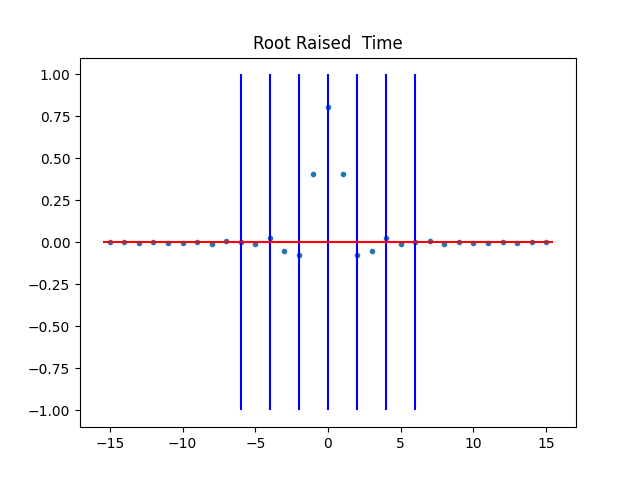

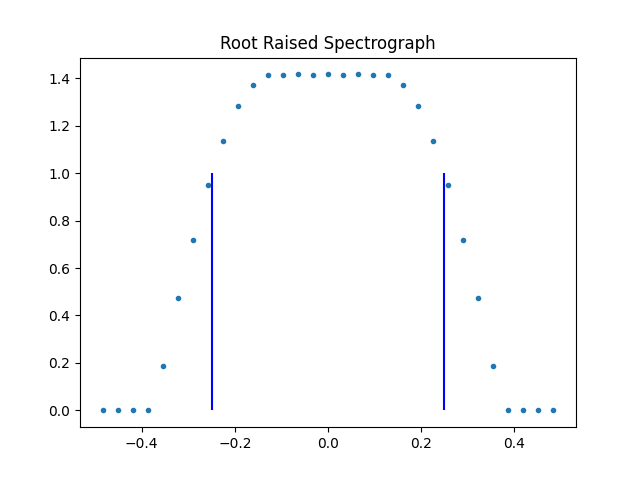

In [10]:
# Now make the raised cosine filter. This is done to create a matched filter for the tx and rx sides. 
#Note that the impulse response is non-zero @ +/Tsym for the Root Raised cos filter unlike the Raised Cos filter.
def rootRaisedCos(ntaps, sps, excess_bw):
    n = np.arange(ntaps) - (ntaps-1)//2

    #avoid divide by 0 issue in rrc equation due to excess BW collision
    while sps/(4*excess_bw) in n:
        excess_bw += .001

    a = excess_bw
    print(f"Correct BW: {a}")
    
    #Gracefully ignore divide by 0 when n=0
    with np.errstate(divide='ignore', invalid='ignore'):
        rrc = np.cos(np.pi*(1+a)*n/sps) + sps/(4*a*n) * np.sin(np.pi*(1-a)*n/sps)
        rrc *= 4*a/(np.pi*np.sqrt(sps)) / (1 - (4*a*n/sps)**2)
        
    #Handle divide by zero condition when n=0
    rrc[np.argwhere(np.isnan(rrc))] = (1+a*(4/np.pi-1))/np.sqrt(sps)
    
    return n, rrc

n, rrc = rootRaisedCos(ntaps, sps, .51)

%matplotlib widget
plt.close('all')
plt.figure("Root Raised over Time")
plt.title("Root Raised  Time")
plt.plot(n, rrc, '.')
plt.vlines(np.arange(-3*sps, 3*sps+1, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show()

yf = fft.fft(rrc)
freqs = fft.fftfreq(rrc.size)

plt.figure("Root Raised Spectrograph")
plt.title("Root Raised Spectrograph")
plt.plot(freqs, np.abs(yf), '.')
plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()

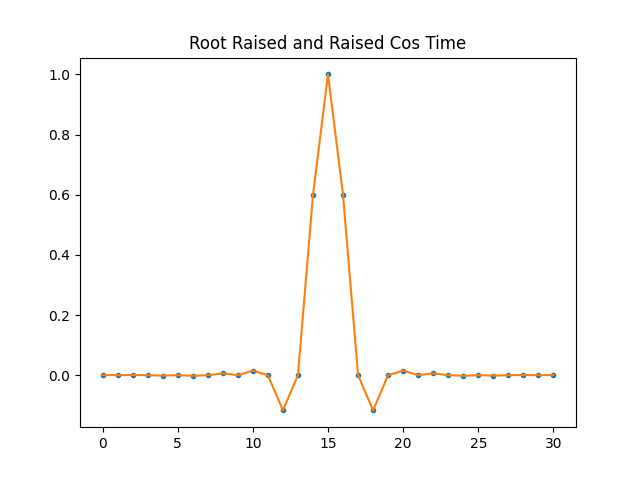

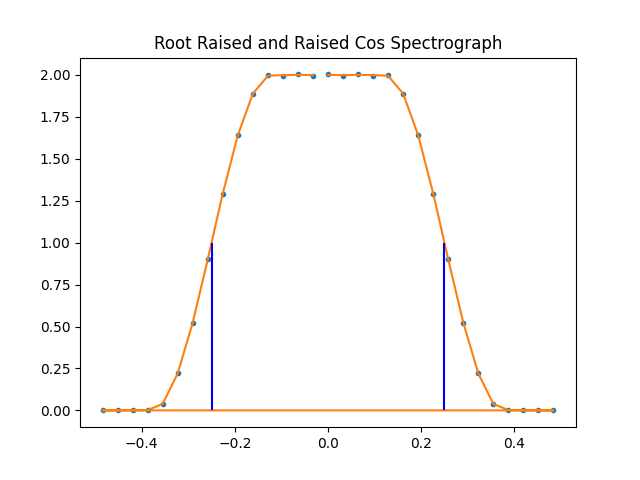

In [11]:
#Verify that 2 RRC is equal to a raised cos filter. This is to check that the algorithm is correct
rrc2 = signal.convolve(rrc, rrc, mode='same')

%matplotlib widget
plt.close('all')
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(rrc2, '.')
plt.plot(root_raised, '-')
plt.show()

yf_rrc2 = fft.fft(rrc2)
freqs_rrc2 = fft.fftfreq(rrc2.size)

yf_rc = fft.fft(root_raised)
freqs_rc = fft.fftfreq(root_raised.size)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs_rrc2, np.abs(yf_rrc2), '.')
plt.plot(freqs_rc, np.abs(yf_rc), '-')
plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()



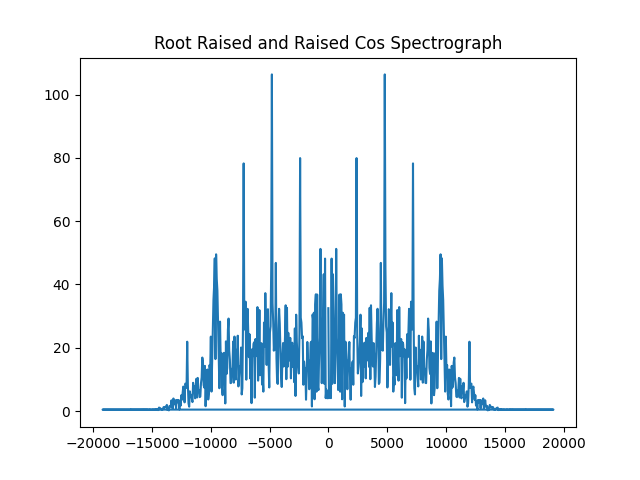

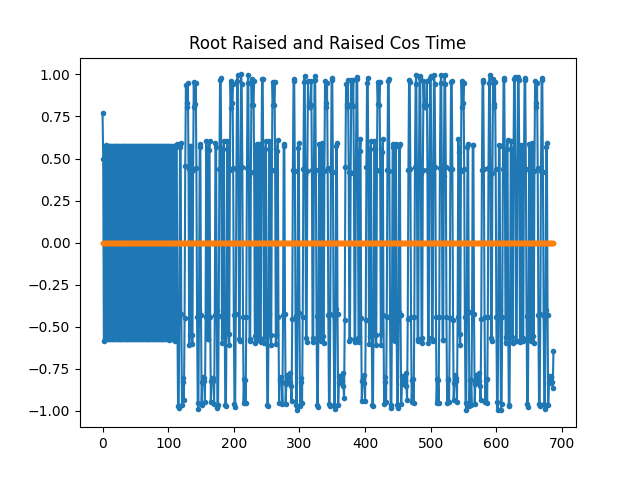

In [12]:
# apply RRC to modulated signal. This is the transmitted signal.
#symbols2 = np.concatenate([np.zeros(500*2), symbols, np.zeros(500*2)])
tx_waveform = signal.convolve(symbols, rrc, mode='same')
tx_waveform /= np.max(np.abs(tx_waveform))

%matplotlib widget
plt.close('all')
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(tx_waveform.real, '.-')
plt.plot(tx_waveform.imag, '.-')
plt.show

yf = fft.fft(tx_waveform)
freqs = fft.fftfreq(tx_waveform.size, d=1/fs)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

In [13]:
#Write TX to file in case you want to transmit
(tx_waveform.astype(np.complex64)).tofile("tx_waveform.iq")

## Channel Modeling
Now that we have the transmit waveform, we need to model how the signal will look like once it arrives at the receiver. The following factors need to be taken into account:
1. Additive White Gaussian Noise (AWGN). Take a signal to noise parameter to determine how much noise to add
2. Frequency offset. This is to model clock disparaties b/t the transmitter and receiver.
3. Phase offset. The signal will arrive at the receiver at an unknown period in time

Tx Variance 0.040458649671061775
Max Noise voltage so that SNR < 10dB 0.04870683308124783
63
Noise power: 0.9899796026984867


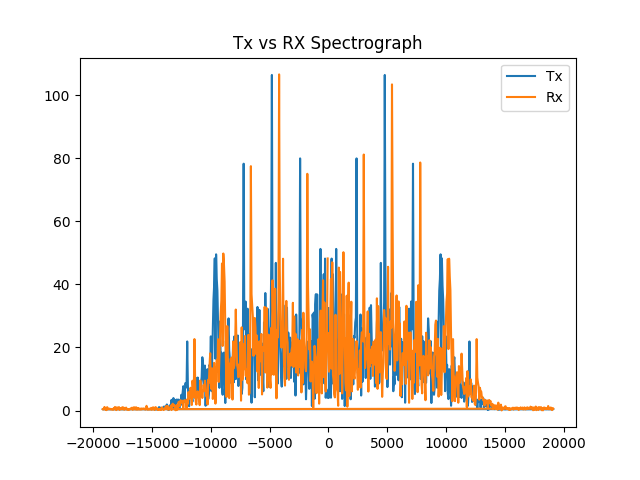

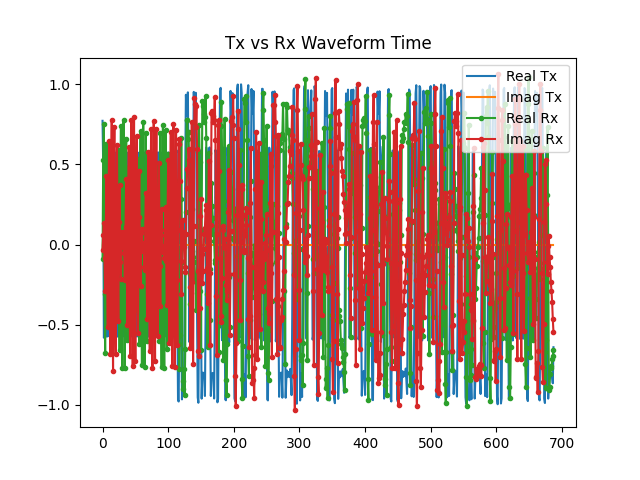

In [14]:
# Model Channel
def channel_model(input_sig, noise_voltage, fractional_samp_delay, samp_rate, freq_offset, padding):
    
    #Add fractional sample delay/phase offset using Whittaker–Shannon interpolation formula (https://tomroelandts.com/articles/how-to-create-a-fractional-delay-filter)
    N = 2**6 - 1 # Number of taps. This number was semi-arbitrarily picked 
    print(N)
    n = np.arange(-N//2, N//2) # 0 Center taps
    h = np.sinc(n-fractional_samp_delay)
    h *= np.hamming(N) #Window filter to ensure it decays to 0
    h /= np.sum(h)     #Normalize filter so there's 0dB gain

    phase_shifted = signal.convolve(input_sig, h, mode='same')

    # Frequency offset
    t = np.linspace(0, 1/samp_rate*len(input_sig), len(input_sig))
    freq_shifted = phase_shifted * np.exp(2j*np.pi*freq_offset*t)

    #Add

    #Add AWGN
    noise = (np.random.randn(len(freq_shifted)) + 1j*np.random.randn(len(freq_shifted)))/np.sqrt(2)
    print(f"Noise power: {np.var(noise)}")
    output_sig = freq_shifted + noise_voltage*noise
    
    return output_sig



print(f"Tx Variance {np.var(np.abs(tx_waveform))}")
max_noise = np.var(tx_waveform)/(10)
print(f"Max Noise voltage so that SNR < 10dB {max_noise}")

rx_waveform = channel_model(tx_waveform, max_noise*.5, .3, fs, 0.62e3, 0)

%matplotlib widget
plt.figure("Tx vs Rx Waveform Time")
plt.title("Tx vs Rx Waveform Time")
plt.plot(tx_waveform.real)
plt.plot(tx_waveform.imag)
plt.plot(rx_waveform.real, '.-')
plt.plot(rx_waveform.imag, '.-')

plt.legend(['Real Tx', 'Imag Tx', 'Real Rx', 'Imag Rx'])
plt.show

rx_yf = fft.fft(rx_waveform)
rx_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)

tx_yf = fft.fft(tx_waveform)
tx_freqs = fft.fftfreq(tx_waveform.size, d=1/fs)

plt.figure("Tx vs RX Spectrograph")
plt.title("Tx vs RX Spectrograph")
plt.plot(tx_freqs, np.abs(tx_yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.legend(['Tx', 'Rx'])
plt.show()


## Demodulate
Demodulation will consist of 
1. Coarse Frequency Syncronization. This can be done using:
    * FLL Band-edge
    * M'th power law
2. Apply Root Raised Cosine Filter (LPF & Matched Filter)
4. Timing Synchronization. This can be done by:
    * Polyphase clock recovery Correlating on the syncword after the syncword has been passed through a raised cosine filter. (I think this will be computationally intensive)
    * PLL Based Syncronization
        * Drive derivative of matched filter to zero (min of 2 SPS)
            * maximum likelihood
            * early late 
        * Aligning one of the samples w/ zero crossings (min of 2 SPS)
            * zero crossing
            * Gardner
        * Mueller & Mueller (min of 1 sps)
6. Fine Frequency Syncronization
7. Demodulation
8. De-packetization

Per [fred harris](https://www.youtube.com/watch?v=Zmjk9NE-3k0) Band edge filtering can be used to determine both carrier and phase offset (Timing & Freq Sync)

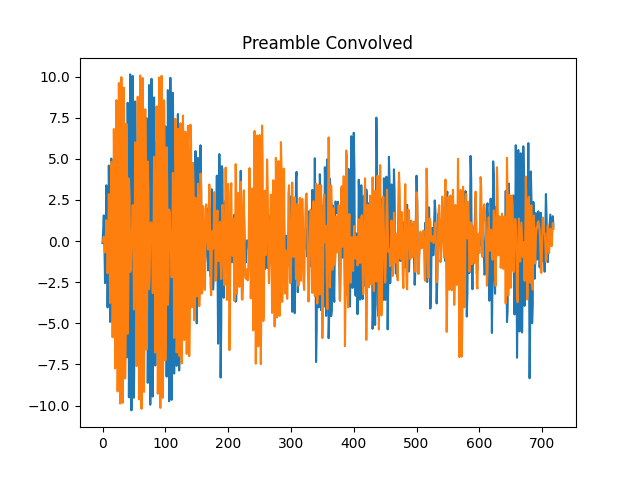

[-9079.2767733  -9025.86926287]


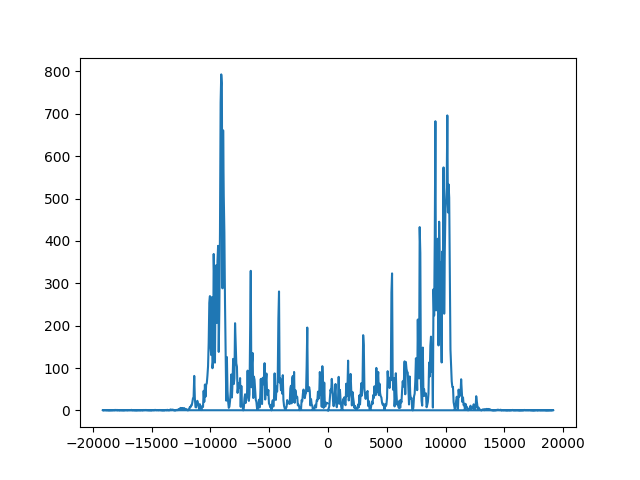

In [15]:
# Coarse frequency correction using preamble and FLL band edge - incomplete
preamble = unpack_bits(np.array([0xAA,0xAA], np.uint8), sps)
preamble = psk_mod(preamble, bpsk_symbol_map)
preamble = signal.convolve(preamble, rrc, mode='same')

matched = signal.convolve(preamble, rx_waveform)

%matplotlib widget
plt.figure("Preamble Convolved")
plt.title("Preamble Convolved")
plt.plot(matched.real)
plt.plot(matched.imag)
plt.show()

yf = fft.fft(matched)
freqs = fft.fftfreq(matched.size, d=1/fs)
print(freqs[np.abs(yf)>750])

plt.figure("Preamble Convolved vs RX")
plt.plot(freqs, np.abs(yf))
#plt.plot(rx_freqs, np.abs(rx_yf))
#plt.legend(['Preamble', 'Unfiltered Rx'])
plt.show()

Freq offset: 613.953488372093
nfft: 688
nfft: 1024
D Freq offset: 920.9302325581396


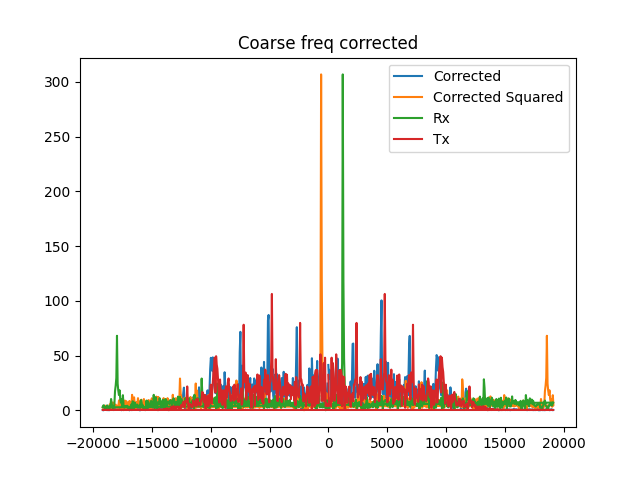

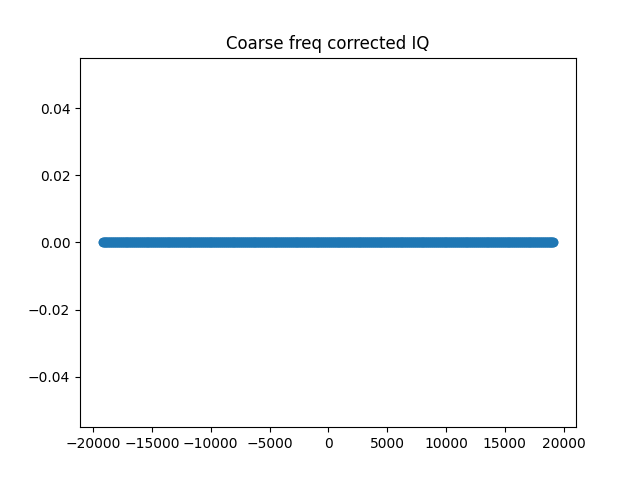

In [16]:
# Coarse frequency correction using M-th power law described in pysdr and pg. 517 of Principles of Communications
corrected_yf = fft.fft(rx_waveform**2)
corrected_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)
freq_offset = corrected_freqs[np.argmax(np.abs(corrected_yf))]/2
print(f"Freq offset: {freq_offset}")
print(f"nfft: {len(corrected_yf)}")

def coarse_freq_correction(samples, samp_rate, nfft=None):
    # Computationally simplified
    d_corrected_yf = fft.fft(samples**2, nfft)
    d_corrected_freqs = fft.fftfreq(samples.size, d=1/samp_rate)
    d_freq_offset = d_corrected_freqs[np.argmax(np.abs(d_corrected_yf))]/2
    print(f"D Freq offset: {d_freq_offset}")

    d_freq_offset_time = np.arange(len(samples))/samp_rate * -1
    return samples*np.exp(2j*np.pi*d_freq_offset*d_freq_offset_time)


nfft = 2**10
print(f"nfft: {nfft}")
coarse_freq_corr = coarse_freq_correction(rx_waveform, fs, nfft)

%matplotlib widget
plt.close('all')

rx_yf = fft.fft(rx_waveform**2)
rx_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)

corrected_yf = fft.fft(coarse_freq_corr)
corrected_sq_yf = fft.fft(coarse_freq_corr**2)
corrected_freqs = fft.fftfreq(coarse_freq_corr.size, d=1/fs)

plt.figure("Coarse freq corrected Spectrograph")
plt.title("Coarse freq corrected")
plt.plot(corrected_freqs, np.abs(corrected_yf))
plt.plot(corrected_freqs, np.abs(corrected_sq_yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.plot(tx_freqs, np.abs(tx_yf))

plt.legend(['Corrected', 'Corrected Squared', 'Rx', 'Tx'])
plt.show()

plt.figure("Coarse freq corrected IQ")
plt.title("Coarse freq corrected IQ")
plt.scatter(corrected_freqs.real, corrected_freqs.imag)
plt.show()

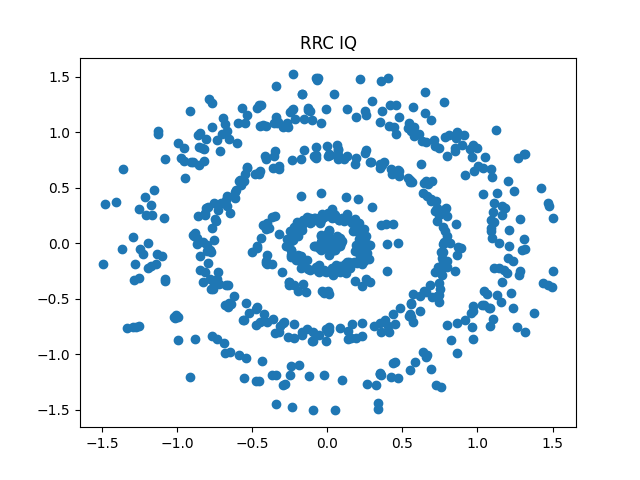

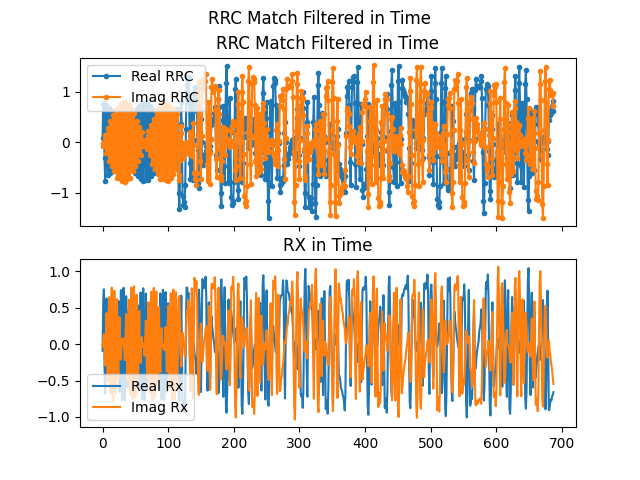

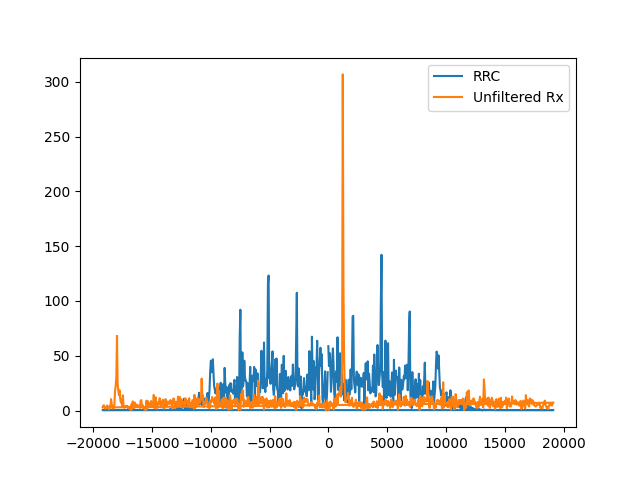

In [17]:
# Apply RRC
rrc_match_filtered = signal.convolve(coarse_freq_corr, rrc, mode='same')

%matplotlib widget
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle("RRC Match Filtered in Time")
ax[0].set_title("RRC Match Filtered in Time")
ax[0].plot(rrc_match_filtered.real, '.-')
ax[0].plot(rrc_match_filtered.imag, '.-')
ax[0].legend(['Real RRC', 'Imag RRC'])

ax[1].set_title("RX in Time")
ax[1].plot(rx_waveform.real)
ax[1].plot(rx_waveform.imag)

plt.legend(['Real Rx', 'Imag Rx'])


yf = fft.fft(rrc_match_filtered)
freqs = fft.fftfreq(rrc_match_filtered.size, d=1/fs)

plt.figure("RRC Match Filtered Spectrum vs RX")
plt.plot(freqs, np.abs(yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.legend(['RRC', 'Unfiltered Rx'])

plt.figure("RRC IQ")
plt.title("RRC IQ")
plt.scatter(rrc_match_filtered.real, rrc_match_filtered.imag)
plt.show()

628
56.0


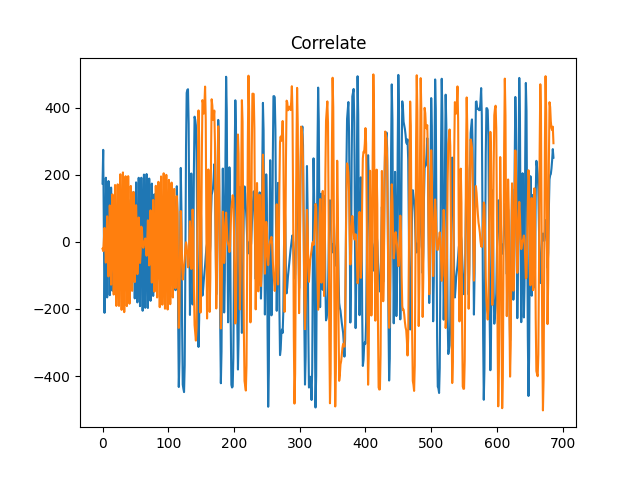

In [18]:
# Time Sync - I'm going to try doing this by correlating with the syncword
syncword_bits = unpack_bits(np.array(syncword, np.uint8), sps)
syncword_mod = psk_mod(syncword_bits, bpsk_symbol_map)
syncword_mod = signal.convolve(syncword_mod, rrc, mode='same')
syncword_mod = signal.convolve(syncword_mod, rrc, mode='same')


correlate = signal.correlate(rrc_match_filtered, syncword, mode='valid')

print(np.argmax(np.abs(correlate)))
print(sps*3*8+sps*8/2)

%matplotlib widget
plt.figure("Correlate")
plt.title("Correlate")
plt.plot(correlate.real)
plt.plot(correlate.imag)
plt.show()


In [19]:
# Time Sync - Generic
#TODO need to test for SNR performance and time to timing lock



def time_sync_pll(samples, resample_ratio, samples_per_symbol, timing_error_detector, Kp, Ki, plot_title=False):
    interp_signal = signal.resample_poly(samples, resample_ratio, 1)
    interp_sps = samples_per_symbol*resample_ratio
    i = interp_sps
    i_out = -1
    print(f"Shape interp signal {np.shape(interp_signal)}")
    print(f"Shape samples {np.shape(samples)}")
    print(f"Interp SPS: {interp_sps}")
    new_sample_pts = np.zeros(np.shape(interp_signal), int) - 1
    error = 0
    error_log = np.zeros(np.shape(interp_signal), int) - 1
    error_integral = 0



    while i + interp_sps < len(interp_signal)+1:
        i_out += 1
        #error += np.abs(timing_error_detector(interp_signal, i, interp_sps))*interp_sps
        error = np.real(timing_error_detector(interp_signal, i, interp_sps))
        error_integral += Ki*error
        output = Kp*error +  error_integral
        i += interp_sps + int(output*interp_sps)

        #Remove edge case where pll updates past last symbol
        if i_out < len(new_sample_pts):
            new_sample_pts[i_out] = i
            error_log[i_out] = error
        else:
            i_out -= 1
            break
        
        
    print("new_sample_pts: ", len(new_sample_pts))
    print(f"len internp signal {len(interp_signal)}")
    print(f"I out: {i_out} new_sample_pts[i_out] {new_sample_pts[i_out]}")
    output = interp_signal[new_sample_pts[:i_out]]
    #print(len(new_sample_pts))
    print(f"Len Output {len(output)}")
    
    if plot_title:
        
        %matplotlib widget
        plt.figure(plot_title + " Upsampled Time")
        plt.title(plot_title + " Upsampled Time")
        plt.plot(interp_signal.real)
        plt.plot(interp_signal.imag)
        plt.vlines(new_sample_pts[:i_out], -2, 2)
        plt.show()
        
        plt.figure(plot_title + "IQ")
        plt.title(plot_title + "IQ")
        plt.scatter(output.real, output.imag)
        plt.show()
        
        plt.figure(plot_title + " Downsampled Time")
        plt.title(plot_title + " Downsampled Time")
        plt.plot(new_sample_pts[:len(output)], output.real, '.-')
        plt.plot(new_sample_pts[:len(output)], output.imag, '.-')
        plt.plot(new_sample_pts[:len(output)], error_log[:len(output)], '.-')
        plt.show()
    return output


Shape interp signal (22016,)
Shape samples (688,)
Interp SPS: 64
new_sample_pts:  22016
len internp signal 22016
I out: 342 new_sample_pts[i_out] 22016
Len Output 342


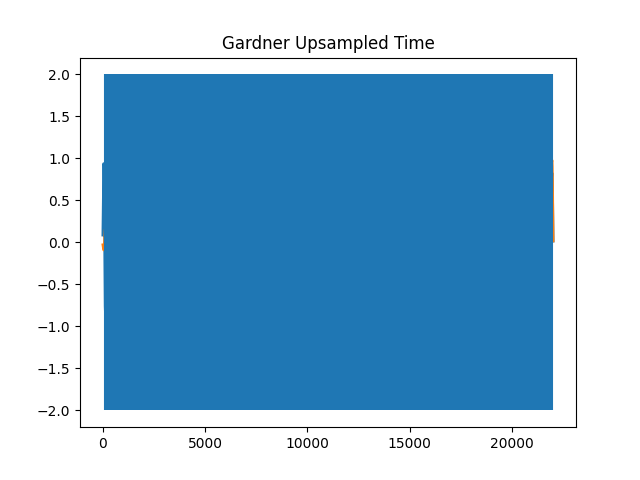

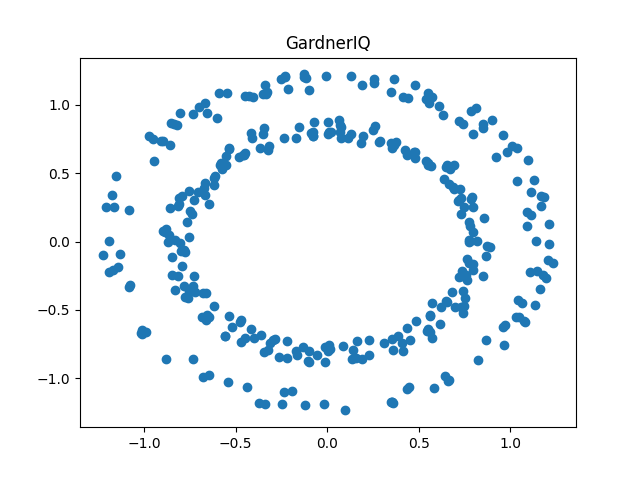

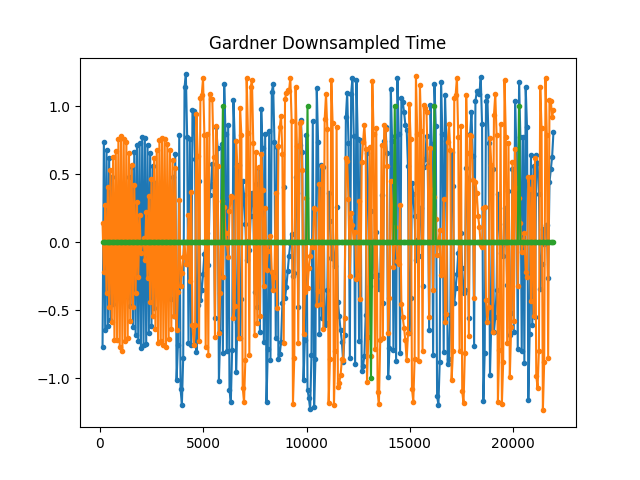

Shape interp signal (22016,)
Shape samples (688,)
Interp SPS: 64
new_sample_pts:  22016
len internp signal 22016
I out: 342 new_sample_pts[i_out] 22016
Len Output 342


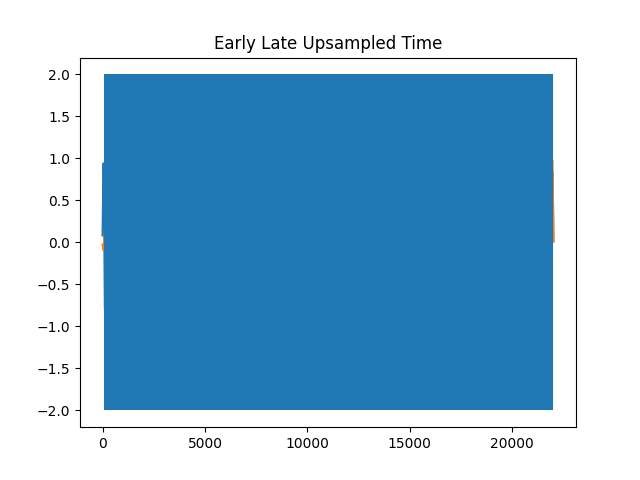

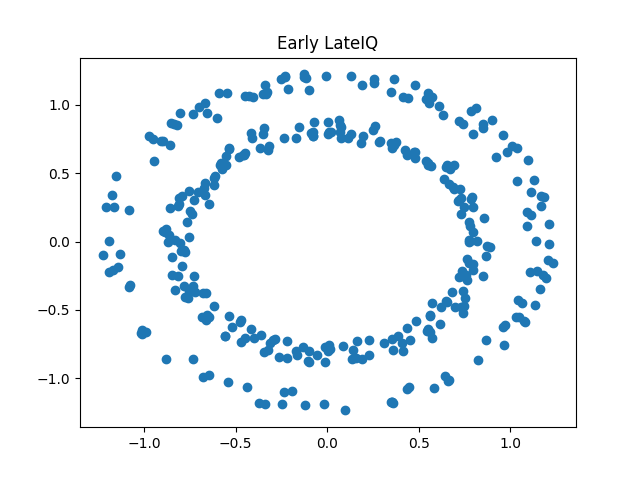

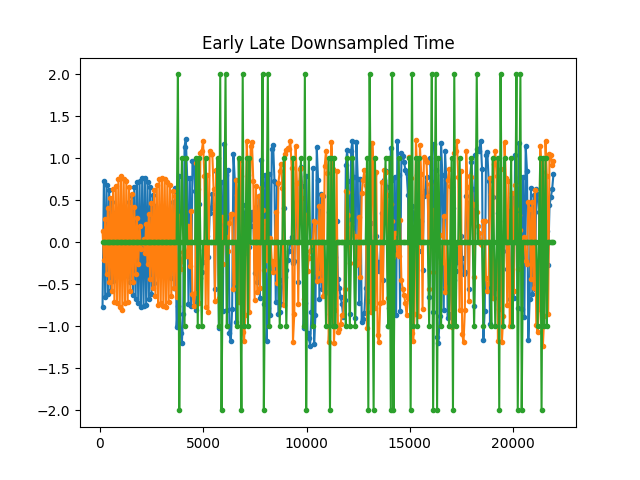

Gardner Variance: 0.03457339059892583
Early Late Variance: 0.03457339059892583


In [20]:
def gardner_TED(signal, sample_pos, sps):
    error = signal[sample_pos-int(sps/2)] * (signal[sample_pos] - signal[sample_pos-sps])
    return error.real + error.imag
def early_late_TED(signal, sample_pos, sps): 
    error = signal[sample_pos] * (signal[sample_pos+int(sps/2)] - signal[sample_pos-int(sps/2)])
    return error.real + error.imag
#early_late_TED = lambda signal, sample_pos, sps: np.abs(signal[sample_pos]) * (np.abs(signal[sample_pos+int(sps/2)]) - np.abs(signal[sample_pos-int(sps/2)]))
plt.close("all")
interp_factor = 32  #Arbitrarily chosen. Needs to have multiple SPS

# Test Gardner
gardner_out = time_sync_pll(rrc_match_filtered, interp_factor, sps, gardner_TED, .008, .00005, plot_title="Gardner")


#Test Early-Late
early_late_out = time_sync_pll(rrc_match_filtered, interp_factor, sps, early_late_TED, .006, .0001, plot_title="Early Late")


print(f"Gardner Variance: {np.var(np.abs(gardner_out))}")
print(f"Early Late Variance: {np.var(np.abs(early_late_out))}")


In [21]:
plt.close("all")
interp_factor = 128  #Arbitrarily chosen. Needs to have multiple SPS
def mueller_and_mueller(signal, sample_pos, sps): 
    derivative = signal[sample_pos] - signal[sample_pos-1]
    error = signal[sample_pos]*derivative

    return error.real + error.imag
ml_out = time_sync_pll(rrc_match_filtered, interp_factor, sps, ml_TED, plot_title="ML")
print(f"ML Variance: {np.var(np.abs(ml_out))}")
print(f"SPS {sps}")
print(f"Len Unpacked {len(unpacked)/sps}")
print(f"Len ml out {len(ml_out)}")

NameError: name 'ml_TED' is not defined

In [ ]:
# Time Sync - Mueller & Mueller
#TODO need to test for SNR performance and time to timing lock
interp_factor = 128*2  #Arbitrarily chosen 
interp_signal = signal.resample_poly(rrc_match_filtered, interp_factor, 1)
interp_sps = sps*interp_factor

i = interp_sps
i_out = 0
new_sample_pts = np.zeros(np.shape(interp_signal), int) - 1
error_log = np.zeros(np.shape(interp_signal), float) - 1
phase_offset = 0
dt = int(interp_sps/2)
print(dt)
while i + interp_sps < len(interp_signal):
    phase_offset = (interp_signal[i] * interp_signal[i-dt] - interp_signal[i+dt])
    phase_offset = phase_offset.real + phase_offset.imag
    #print("interp_signal[i-dt].real: ", interp_signal[i-dt].real)
    #phase_offset += interp_signal[i].real * (interp_signal[i-dt].real - interp_signal[i+dt].real)
    #print(phase_offset)
    i += int(interp_sps + phase_offset)
    error_log[i_out] = phase_offset
    phase_offset = phase_offset - int(phase_offset.real)
    new_sample_pts[i_out] = i
    
    i_out += 1

early_late_out = interp_signal[new_sample_pts[:i_out]]

%matplotlib widget
plt.close("all")
plt.figure("Early-Late Upsampled Time")
plt.title("Early-Late Upsampled Time")
plt.plot(interp_signal.real)
plt.plot(interp_signal.imag)
plt.vlines(new_sample_pts[:i_out], -2, 2)

plt.figure("Early-Late IQ")
plt.title("Early-Late IQ")
plt.scatter(early_late_out.real, early_late_out.imag)

plt.figure("Early-Late Downsampled Time")
plt.title("Early-Late Downsampled Time")
plt.plot(new_sample_pts[:i_out], early_late_out.real, '.-')
plt.plot(new_sample_pts[:i_out], early_late_out.imag, '.-')
plt.plot(new_sample_pts[:len(early_late_out)], error_log[:len(early_late_out)], '.-')
plt.show()

print("Error Log: ", error_log[:60])
print(f"Error average: {np.average(error_log)}")
#print(np.packbits([early_late_out[1:]>0]*1) == packet)
print((early_late_out[1:]>0)*1)

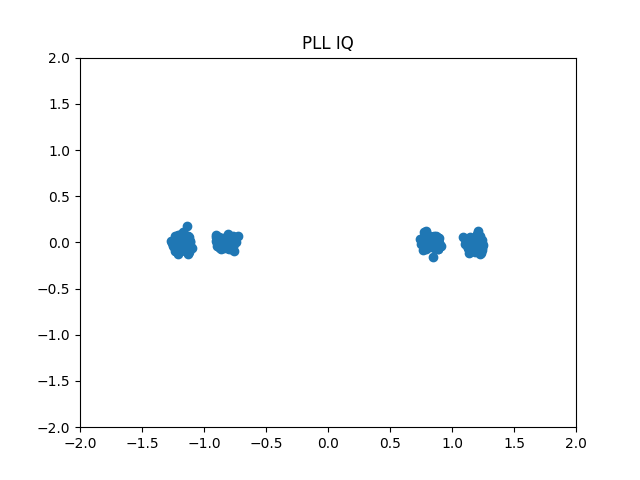

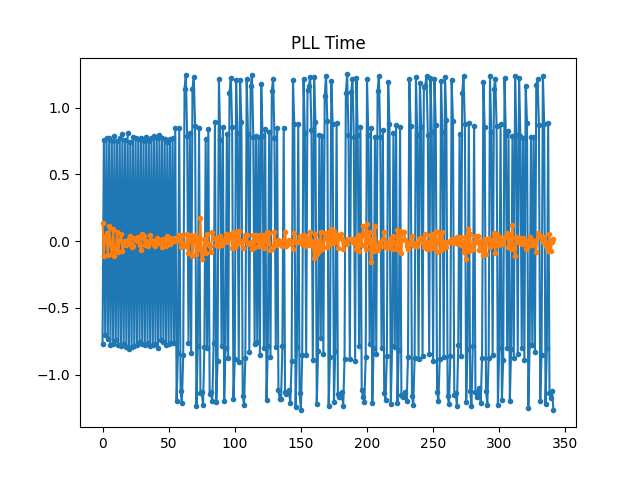

In [22]:
# Fine frequency syncronization using PLL/costas loop
# The PLL is properly tuned if the samples converge onto 2 points. If the points remain in a circle, that means that the PLL has not been able to lock
pll_in = gardner_out
pll_in = early_late_out




def fine_freq_corr(samples, Kp, Ki):
    pll_phase = 0
    pll_freq = 0

    error_log = []
    freq_log = []
    
    pll_out = np.empty(len(samples), dtype=complex)

    for i in range(len(pll_in)):
        pll_out[i] = samples[i] * np.exp(-1j*pll_phase)
        error = pll_out[i].real * pll_out[i].imag   #Error formula for 2nd order costas loop (BPSK)
        error_log.append(error)
        #print(f"Error {error}")
    
        #Update loop 
        pll_freq += (Kp * error)
        freq_log.append(pll_freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
        pll_phase += pll_freq + (Ki * error)
    
        pll_phase = np.fmod(pll_phase, 2*np.pi)    
        i+=1
    return pll_out

pll_out = fine_freq_corr(gardner_out, 1, .3)

%matplotlib widget
plt.close('all')
plt.figure("PLL IQ")
plt.title("PLL IQ")
plt.scatter(pll_out[8*4:].real, pll_out[8*4:].imag)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

plt.figure("PLL Time")
plt.title("PLL Time")
plt.plot(pll_out.real, '.-')
plt.plot(pll_out.imag, '.-')
#plt.plot(freq_log)
#plt.plot(error_log)
plt.show()

In [23]:
#Demodulate
#bits = (early_late_out > 0)*1
bits = (pll_out > 0)*1
print(bits)


[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1
 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1
 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0
 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0
 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0
 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0
 1 1 0 0 1 0 0 0 0]


In [24]:
# Depacketize
# Correlate Preamble
def get_msg(bits, syncword):
    '''
    Returns the Body of the Message by correlating the syncword against the input bits. 
    Corrects for phase ambiguity by also comparing the inverse of the syncword.

    '''
    syncword_bits = unpack_bits(np.array([syncword], np.uint8), 1)
    syncword_bits_inv = (~(syncword_bits>0))*1 #^ syncword_bits

    sync_corr = signal.correlate(bits, syncword_bits, mode='valid')
    sync_corr_inv = signal.correlate(bits, syncword_bits_inv, mode='valid')

    #find packet start
    #need to make sure that max(sync_corr) is equal to the power of the syncword (6 for 11010111)
    msg = np.zeros([])
    if (np.max(sync_corr) == np.sum(syncword_bits)):
        print("Sync")
        #For different sync words might need change the offset from the correlation location
        corr_loc = np.argmax(sync_corr)# - int(len(syncword_bits)/2)
        
        if (bits[corr_loc:corr_loc+len(syncword_bits)] == syncword_bits).all():
            msg = bits[corr_loc+len(syncword_bits_inv):]
    elif (np.max(sync_corr_inv) == np.sum(syncword_bits_inv)):
        print("Sync Inv")
        corr_loc = np.argmax(sync_corr_inv)
        
        if (bits[corr_loc:corr_loc+len(syncword_bits_inv)] == syncword_bits_inv).all():
            msg = bits[corr_loc+len(syncword_bits_inv):]
            msg = (msg < 1) * 1 #Invert
        else:
            print(f"Inv Correlation Array:\n {sync_corr_inv}")
            print(f"Correlation Location: {corr_loc}")
    if msg.any():
        print(f"Packet: {msg}")
        packet = np.packbits(msg)
        packet_len = packet[0]
        message = packet[1:packet_len+1]
        
        return message.tobytes()

    return 



print(get_msg(bits, syncword))

Sync
Packet: [0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0
 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0
 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0
 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0
 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1
 1 0 0 1 1 0 0 1 0 0 0 0]
b'Biscuit does white collar crimes '


# Let's Try Processing a Real Received Signal
This has a few different paramaters b/c I used GNURadio

In [61]:
# PUll 1 burst from real world receive
rx_raw_1burst = np.fromfile("rx_raw_1burst", np.complex64)

rx_fs = 38.4e3*2
sps = 2 #Although it could be 8 b/c I sampled at 2x the transmit rate
preamble_len = 11
preamble = [0xAA]*preamble_len
print(preamble)
syncword = b"1110010"


[170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170]


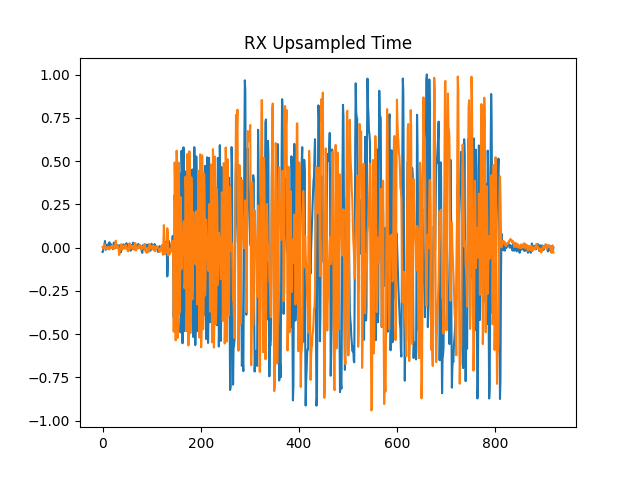

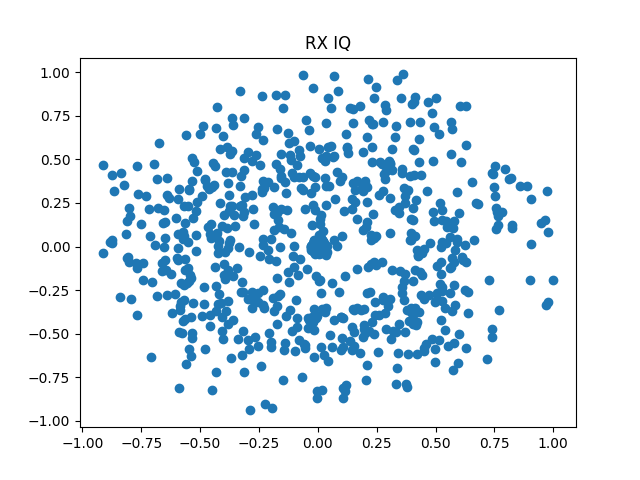

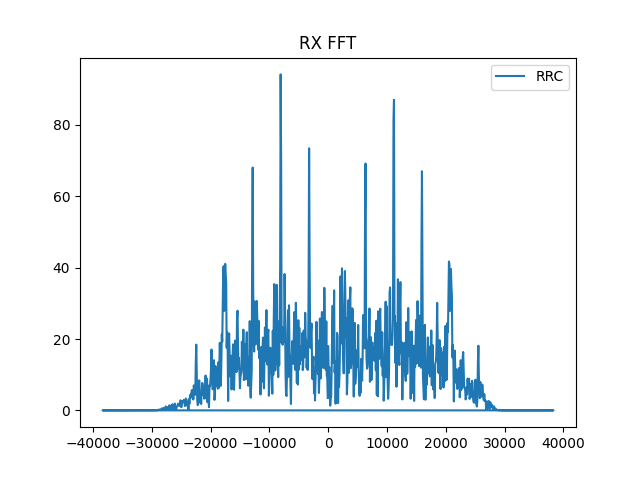

In [62]:
#Plot
%matplotlib widget
plt.close("all")
plt.figure("RX Time")
plt.title("RX Upsampled Time")
plt.plot(rx_raw_1burst.real)
plt.plot(rx_raw_1burst.imag)
plt.show()

plt.figure("RX IQ")
plt.title("RX IQ")
plt.scatter(rx_raw_1burst.real, rx_raw_1burst.imag)
plt.show()

yf = fft.fft(rx_raw_1burst)
freqs = fft.fftfreq(rx_raw_1burst.size, d=1/rx_fs)

plt.figure("RX FFT")
plt.title("RX FFT")
plt.plot(freqs, np.abs(yf))
plt.legend(['RRC', 'Unfiltered Rx'])
plt.show()

nfft: 1024
Len input: 920
D Freq offset: 1544.3478260869565
Freq offset: -8013.913043478261


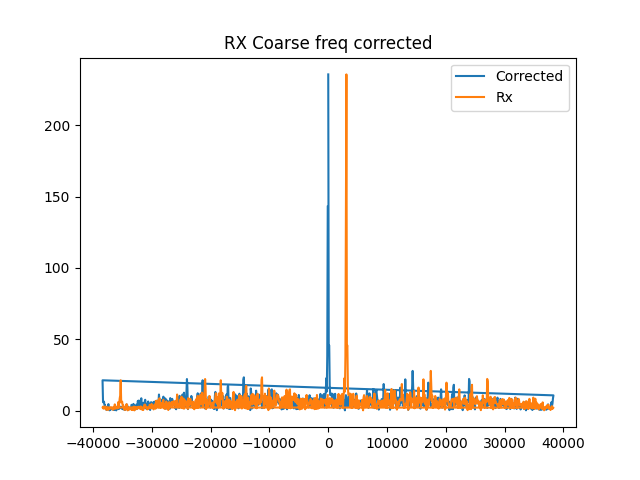

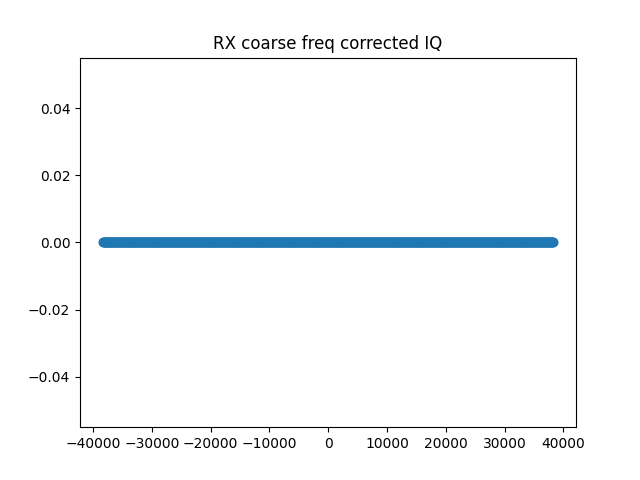

In [63]:
nfft = 2**10
print(f"nfft: {nfft}")
print(f"Len input: {len(rx_raw_1burst)}")
coarse_freq_corr = coarse_freq_correction(rx_raw_1burst, rx_fs)

%matplotlib widget
plt.close('all')

rx_yf = fft.fft(rx_raw_1burst)
rx_freqs = fft.fftfreq(rx_raw_1burst.size, d=1/rx_fs)

rx_sq_yf = fft.fft(rx_raw_1burst**2)
rx_sq_freqs = fft.fftfreq(rx_raw_1burst.size, d=1/rx_fs)

corrected_yf = fft.fft(coarse_freq_corr**2)
corrected_freqs = fft.fftfreq(coarse_freq_corr.size, d=1/rx_fs)

print(f"Freq offset: {rx_sq_freqs[np.argmax(rx_yf)]}")

plt.figure("RX Coarse freq corrected Spectrograph")
plt.title("RX Coarse freq corrected")
plt.plot(corrected_freqs, np.abs(corrected_yf))
#plt.plot(rx_freqs, np.abs(rx_yf))
plt.plot(rx_sq_freqs, np.abs(rx_sq_yf))

plt.legend(['Corrected', 'Rx'])
plt.show()

plt.figure("RX Coarse freq corrected IQ")
plt.title("RX coarse freq corrected IQ")
plt.scatter(corrected_freqs.real, corrected_freqs.imag)
plt.show()

Correct BW: 0.51


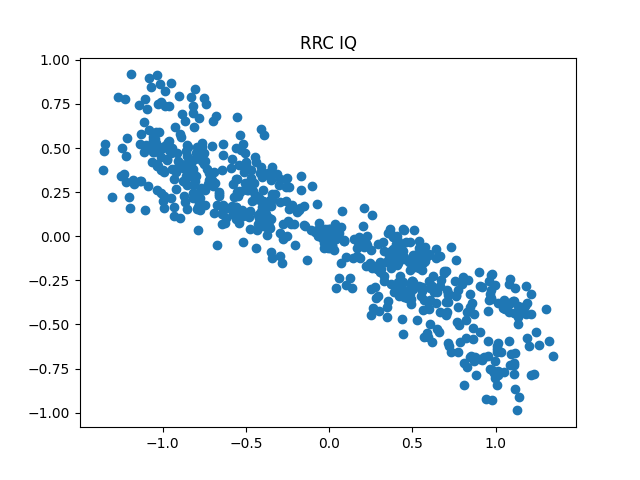

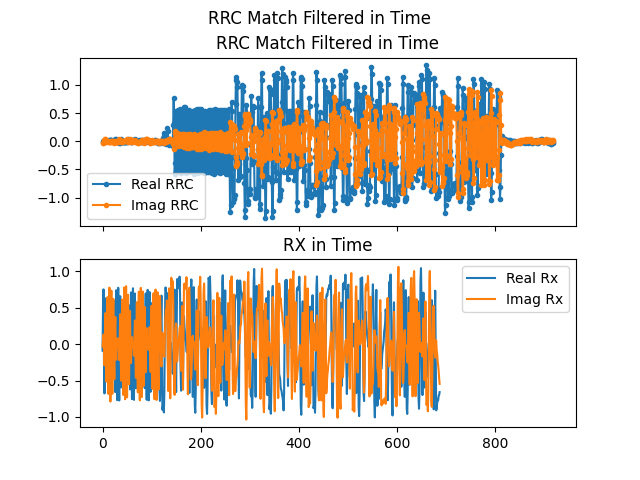

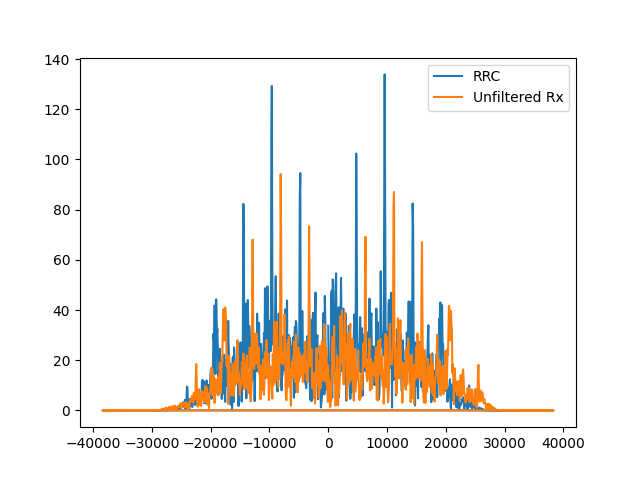

In [64]:
# Apply RRC
#ntaps = 63
#sps=8
n, rx_rrc = rootRaisedCos(ntaps, sps, .51)

rrc_match_filtered = signal.convolve(coarse_freq_corr*1j, rrc, mode='same')

%matplotlib widget
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle("RRC Match Filtered in Time")
ax[0].set_title("RRC Match Filtered in Time")
ax[0].plot(rrc_match_filtered.real, '.-')
ax[0].plot(rrc_match_filtered.imag, '.-')
ax[0].legend(['Real RRC', 'Imag RRC'])

ax[1].set_title("RX in Time")
ax[1].plot(rx_waveform.real)
ax[1].plot(rx_waveform.imag)

plt.legend(['Real Rx', 'Imag Rx'])


yf = fft.fft(rrc_match_filtered)
freqs = fft.fftfreq(rrc_match_filtered.size, d=1/rx_fs)

plt.figure("RRC Match Filtered Spectrum vs RX")
plt.plot(freqs, np.abs(yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.legend(['RRC', 'Unfiltered Rx'])

plt.figure("RRC IQ")
plt.title("RRC IQ")
plt.scatter(rrc_match_filtered.real, rrc_match_filtered.imag)
plt.show()

Shape interp signal (117760,)
Shape samples (920,)
Interp SPS: 256
new_sample_pts:  117760
len internp signal 117760
I out: 458 new_sample_pts[i_out] 117760
Len Output 458


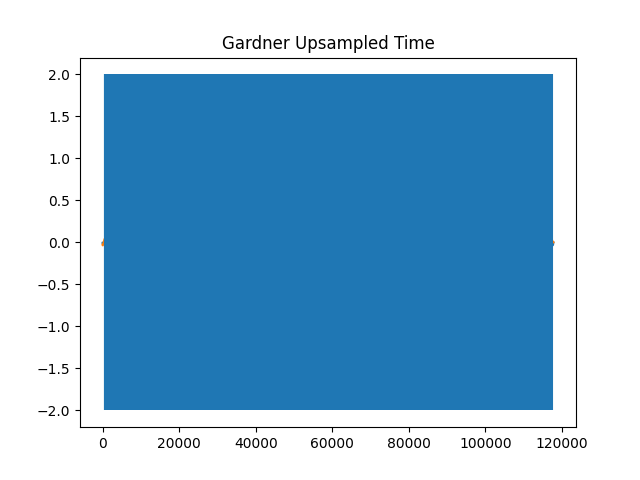

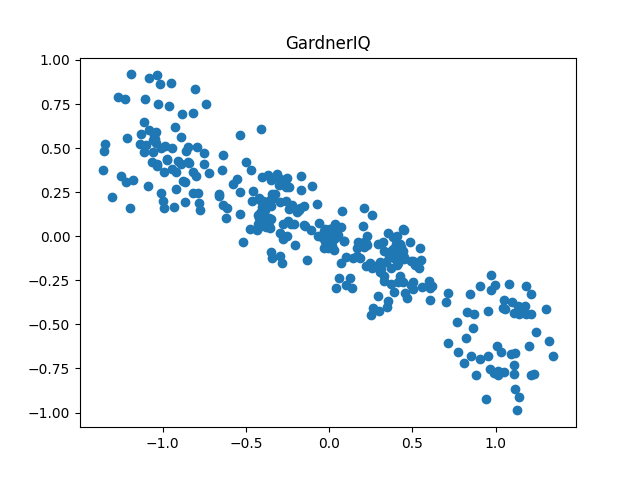

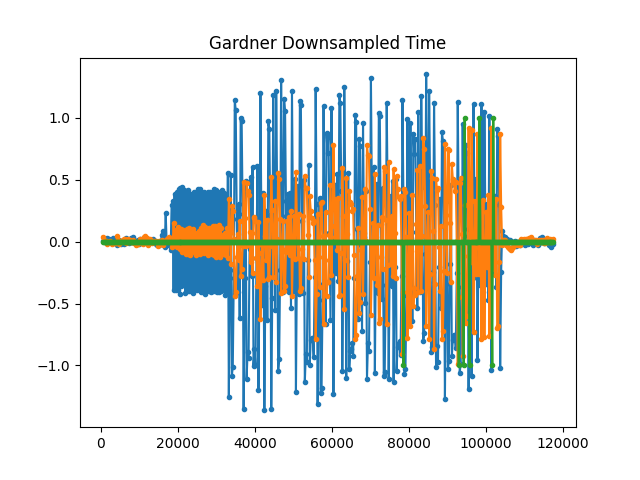

In [65]:
# Try Timing
plt.close("all")
rx_time_sync_out = time_sync_pll(rrc_match_filtered*1, interp_factor, sps, gardner_TED, .00008, .00005, plot_title="Gardner")

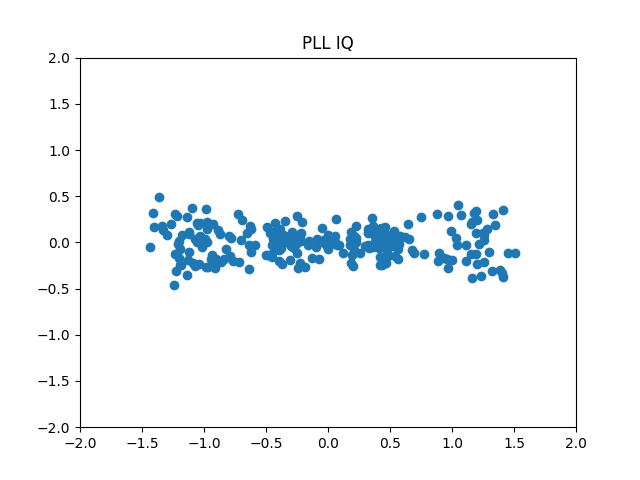

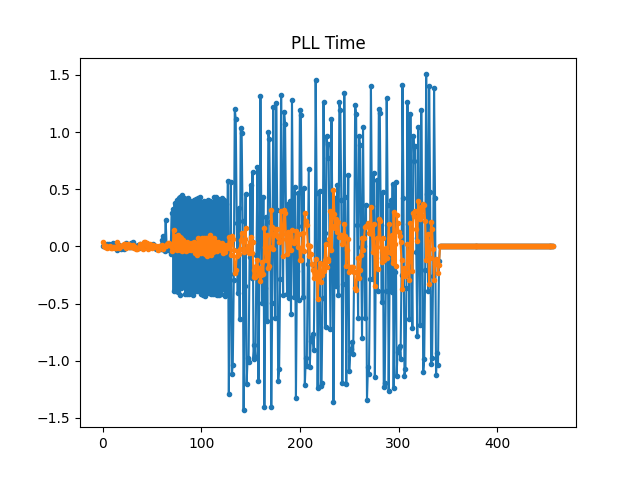

In [70]:
pll_out = fine_freq_corr(rx_time_sync_out, .05, .00005)

%matplotlib widget
plt.close('all')
plt.figure("PLL IQ")
plt.title("PLL IQ")
plt.scatter(pll_out[8*4:].real, pll_out[8*4:].imag)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

plt.figure("PLL Time")
plt.title("PLL Time")
plt.plot(pll_out.real, '.-')
plt.plot(pll_out.imag, '.-')
#plt.plot(freq_log)
#plt.plot(error_log)
plt.show()

In [71]:
bits = (pll_out > 0)*1
print(bits)
print((pll_out < 0)*1)

[1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1
 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0
 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1
 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1
 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0